#Time Series Anomaly Detection using a Kolmogorov Arnold Network

Total samples in dataset: 499
Number of positive samples in dataset: 118
Number of negative samples in dataset: 381
Train samples: 299, Val samples: 100, Test samples: 100
Train - Anomalies: 70, Normals: 229
Validation - Anomalies: 24, Normals: 76
Test - Anomalies: 24, Normals: 76
Epoch 1, Training Positive Predictions: 49.0
Epoch: 0001, Train Loss: 0.1230, Train Acc: 0.6689, Val Loss: 0.1160, Val Acc: 0.8900, Precision: 1.0000, Recall: 0.5417, F1: 0.7027, ROC AUC: 0.8010, Optimal Threshold: 0.4881, Val F1: 0.7368
Epoch 2, Training Positive Predictions: 113.0
Epoch: 0002, Train Loss: 0.1138, Train Acc: 0.7525, Val Loss: 0.1126, Val Acc: 0.9000, Precision: 1.0000, Recall: 0.5833, F1: 0.7368, ROC AUC: 0.8871, Optimal Threshold: 0.5015, Val F1: 0.7692
Epoch 3, Training Positive Predictions: 155.0
Epoch: 0003, Train Loss: 0.1099, Train Acc: 0.7157, Val Loss: 0.1081, Val Acc: 0.9100, Precision: 1.0000, Recall: 0.6250, F1: 0.7692, ROC AUC: 0.8997, Optimal Threshold: 0.5118, Val F1: 0.8000
Ep

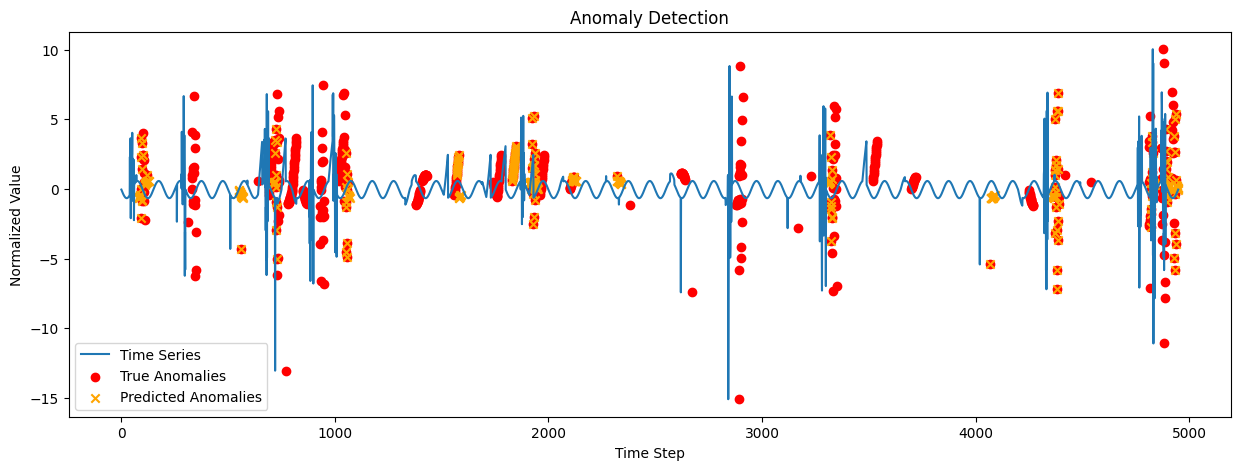

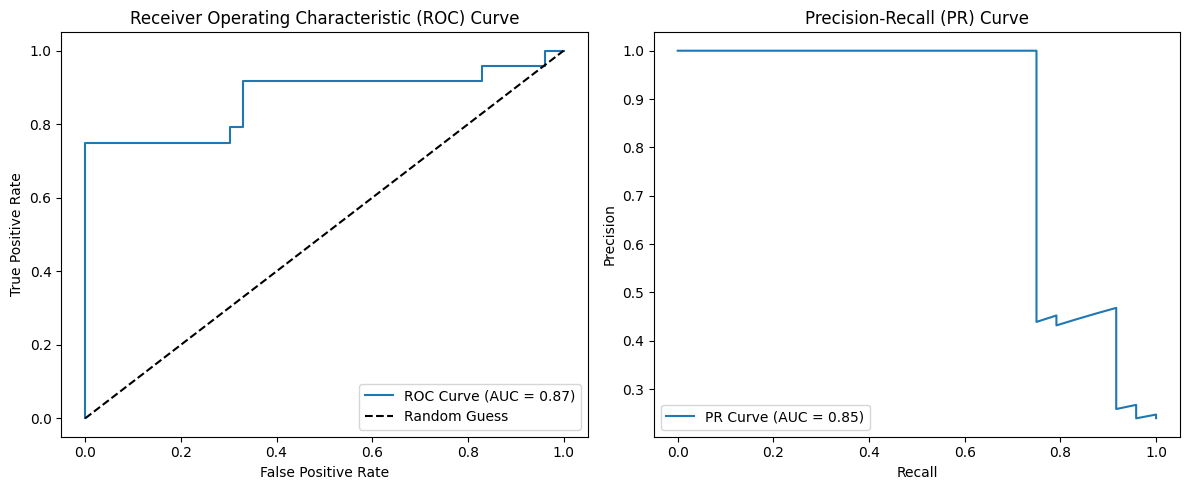

In [11]:
# -*- coding: utf-8 -*-
"""Improved Time Series Anomaly Detection with Adjusted Warnings and Performance"""

# Import necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import random
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    precision_recall_curve,
    roc_curve,
    auc,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
class Args:
    path = "./data/"
    dropout = 0.3  # Adjusted dropout for num_layers=1
    hidden_size = 64  # Reduced hidden size
    n_layers = 1     # Simplified model
    epochs = 200
    early_stopping = 30
    seed = 42
    lr = 1e-3       # Increased learning rate
    window_size = 20
    step_size = 10
    batch_size = 64  # Increased batch size
    anomaly_fraction = 0.1

args = Args()
args.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Adjust dropout if num_layers == 1 to avoid warning
if args.n_layers == 1:
    args.dropout = 0  # No dropout when num_layers == 1 in LSTM

random.seed(args.seed)
np.random.seed(args.seed)
torch.manual_seed(args.seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(args.seed)

# Generate sine wave with anomalies
def generate_sine_wave_with_anomalies(
    length=5000, anomaly_fraction=0.1, window_size=20, step_size=10
):
    x = np.linspace(0, 100 * np.pi, length)
    y = np.sin(x)
    labels = np.zeros(length)
    window_centers = list(range(window_size // 2, length - window_size // 2, step_size))
    num_anomalies = int(len(window_centers) * anomaly_fraction)
    anomaly_centers = np.random.choice(window_centers, num_anomalies, replace=False)
    for center in anomaly_centers:
        anomaly_type = np.random.choice(
            ['point', 'contextual', 'collective', 'trend', 'amplitude_shift']
        )
        if anomaly_type == 'point':
            y[center] += np.random.normal(0, 10)
            labels[center] = 1
        elif anomaly_type == 'contextual':
            y[center] = y[center] * np.random.uniform(1.5, 2.0)
            labels[center] = 1
        elif anomaly_type == 'collective':
            start = max(0, center - window_size // 2)
            end = min(length, center + window_size // 2)
            y[start:end] += np.random.normal(0, 5, size=end - start)
            labels[start:end] = 1
        elif anomaly_type == 'trend':
            end = min(length, center + window_size)
            y[center:end] += np.linspace(0, 5, end - center)
            labels[center:end] = 1
        elif anomaly_type == 'amplitude_shift':
            end = min(length, center + window_size)
            y[center:end] *= np.random.uniform(1.5, 2.0)
            labels[center:end] = 1
    return y, labels

time_series, labels = generate_sine_wave_with_anomalies(
    length=5000,
    anomaly_fraction=args.anomaly_fraction,
    window_size=args.window_size,
    step_size=args.step_size,
)

# Normalize the time series
scaler = StandardScaler()
time_series = scaler.fit_transform(time_series.reshape(-1, 1)).flatten()

# Define the custom dataset with overlapping windows
class TimeSeriesAnomalyDataset(torch.utils.data.Dataset):
    def __init__(
        self, time_series, labels, window_size=20, step_size=10, transform=None
    ):
        self.time_series = time_series
        self.labels = labels
        self.window_size = window_size
        self.step_size = step_size
        self.transform = transform
        self.sample_indices = list(
            range(0, len(time_series) - window_size + 1, step_size)
        )

    def __len__(self):
        return len(self.sample_indices)

    def __getitem__(self, idx):
        if idx >= len(self.sample_indices) or idx < 0:
            raise IndexError(
                f"Index {idx} out of range for sample_indices of length {len(self.sample_indices)}"
            )
        i = self.sample_indices[idx]
        window = self.time_series[i : i + self.window_size]
        window_labels = self.labels[i : i + self.window_size]

        # Input features: window values
        x = torch.tensor(window, dtype=torch.float).unsqueeze(-1)  # Shape: [window_size, 1]

        # Label: 1 if any point in the window is an anomaly, else 0
        y = torch.tensor(1.0 if window_labels.any() else 0.0, dtype=torch.float)

        return x, y

    def indices(self):
        return self.sample_indices

# Create the dataset
dataset = TimeSeriesAnomalyDataset(
    time_series,
    labels,
    window_size=args.window_size,
    step_size=args.step_size,
)

# Verify dataset length and class distribution
print(f"Total samples in dataset: {len(dataset)}")
num_pos = sum([y.item() for _, y in dataset])
num_neg = len(dataset) - num_pos
print(f"Number of positive samples in dataset: {int(num_pos)}")
print(f"Number of negative samples in dataset: {int(num_neg)}")

if num_pos == 0:
    raise ValueError(
        "No positive samples found in the dataset. Adjust window_size or step_size."
    )

# Stratified Splitting
def stratified_split(
    dataset, train_ratio=0.6, val_ratio=0.2, test_ratio=0.2, seed=42
):
    # Extract labels
    labels = [y.item() for _, y in dataset]

    # Split into train+val and test
    train_val_indices, test_indices = train_test_split(
        np.arange(len(labels)),
        test_size=test_ratio,
        stratify=labels,
        random_state=seed,
    )

    # Calculate validation size relative to train_val
    val_relative_ratio = val_ratio / (train_ratio + val_ratio)

    # Split train_val into train and val
    train_indices, val_indices = train_test_split(
        train_val_indices,
        test_size=val_relative_ratio,
        stratify=[labels[i] for i in train_val_indices],
        random_state=seed,
    )

    return train_indices, val_indices, test_indices

train_indices, val_indices, test_indices = stratified_split(dataset, seed=args.seed)

print(
    f"Train samples: {len(train_indices)}, Val samples: {len(val_indices)}, Test samples: {len(test_indices)}"
)

# Count anomalies in each set
def count_anomalies(dataset_subset, name):
    labels = [y.item() for _, y in dataset_subset]
    num_anomalies = int(sum(labels))
    num_normals = len(labels) - num_anomalies
    print(f"{name} - Anomalies: {num_anomalies}, Normals: {num_normals}")

train_dataset = torch.utils.data.Subset(dataset, train_indices)
val_dataset = torch.utils.data.Subset(dataset, val_indices)
test_dataset = torch.utils.data.Subset(dataset, test_indices)

count_anomalies(train_dataset, "Train")
count_anomalies(val_dataset, "Validation")
count_anomalies(test_dataset, "Test")

# Prepare weights for WeightedRandomSampler
targets = [int(y.item()) for _, y in train_dataset]
class_counts = np.bincount(targets)
class_weights = 1.0 / class_counts
samples_weight = [class_weights[t] for t in targets]
samples_weight = torch.DoubleTensor(samples_weight)
sampler = torch.utils.data.sampler.WeightedRandomSampler(
    samples_weight, num_samples=len(samples_weight), replacement=True
)

# Create DataLoaders
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=args.batch_size, sampler=sampler
)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=args.batch_size, shuffle=False
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=args.batch_size, shuffle=False
)

# Implement Focal Loss without pos_weight
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.75, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(
            inputs, targets, reduction='none'
        )
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss
        return F_loss.mean()

criterion = FocalLoss(alpha=0.75, gamma=2)

# Implement CNN-LSTM Model with Batch Normalization
class CNNLSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=1, dropout=0):
        super(CNNLSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(num_features=16)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2)

        self.lstm = nn.LSTM(
            input_size=16, hidden_size=hidden_size, num_layers=num_layers,
            batch_first=True, dropout=dropout
        )
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # x shape: [batch_size, seq_length, input_size]
        x = x.permute(0, 2, 1)  # Reshape for Conv1d: [batch_size, input_size, seq_length]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.permute(0, 2, 1)  # Reshape back for LSTM: [batch_size, seq_length, features]
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(args.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(args.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :]).squeeze()
        return out

# Initialize the model
model = CNNLSTMModel(
    input_size=1,
    hidden_size=args.hidden_size,
    num_layers=args.n_layers,
    dropout=args.dropout
).to(args.device)

# Define optimizer with adjusted weight decay
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr, weight_decay=1e-5)

# Learning rate scheduler without verbose to avoid warnings
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5
)

# Define evaluation metrics
def evaluate_metrics(true_labels, pred_labels, pred_probs):
    precision = precision_score(true_labels, pred_labels, zero_division=0)
    recall = recall_score(true_labels, pred_labels, zero_division=0)
    f1 = f1_score(true_labels, pred_labels, zero_division=0)
    roc_auc_val = roc_auc_score(true_labels, pred_probs)
    return precision, recall, f1, roc_auc_val

# Function to determine optimal threshold based on validation set
def find_optimal_threshold(probs, labels):
    precision_vals, recall_vals, thresholds = precision_recall_curve(labels, probs)
    f1_scores = 2 * (precision_vals * recall_vals) / (precision_vals + recall_vals + 1e-8)
    optimal_idx = np.argmax(f1_scores)
    if optimal_idx < len(thresholds):
        optimal_threshold = thresholds[optimal_idx]
    else:
        optimal_threshold = 0.5  # Default threshold
    optimal_f1 = f1_scores[optimal_idx]
    return optimal_threshold, optimal_f1

# Training and validation loop with early stopping based on F1 score
best_val_f1 = 0
patience = args.early_stopping
patience_counter = 0
optimal_threshold = 0.5  # Initialize with default threshold

for epoch in range(args.epochs):
    # Training Phase
    model.train()
    total_loss = 0
    total_acc = 0
    total_preds_pos = 0  # Monitor number of positive predictions
    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(args.device)
        y_batch = y_batch.to(args.device)
        optimizer.zero_grad()
        out = model(x_batch)  # Output shape: [batch_size]
        loss = criterion(out, y_batch)
        loss.backward()
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        total_loss += loss.item() * x_batch.size(0)
        probs = torch.sigmoid(out)
        preds = (probs > 0.5).float()
        acc = (preds == y_batch).float().mean().item()
        total_acc += acc * x_batch.size(0)
        total_preds_pos += preds.sum().item()
    avg_loss = total_loss / len(train_loader.dataset)
    avg_acc = total_acc / len(train_loader.dataset)

    print(f"Epoch {epoch+1}, Training Positive Predictions: {total_preds_pos}")

    # Validation Phase
    model.eval()
    val_loss = 0
    val_acc = 0
    all_true = []
    all_probs = []
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            x_batch = x_batch.to(args.device)
            y_batch = y_batch.to(args.device)
            out = model(x_batch)
            loss = criterion(out, y_batch)
            val_loss += loss.item() * x_batch.size(0)
            probs = torch.sigmoid(out)
            all_true.extend(y_batch.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    avg_val_loss = val_loss / len(val_loader.dataset)
    # Find Optimal Threshold
    current_threshold, current_f1 = find_optimal_threshold(np.array(all_probs), np.array(all_true))
    # Use optimal threshold for validation metrics
    all_preds_optimal = (np.array(all_probs) > current_threshold).astype(float)
    precision, recall, f1, roc_auc_val = evaluate_metrics(all_true, all_preds_optimal, all_probs)
    avg_val_acc = (all_preds_optimal == np.array(all_true)).mean()

    print(
        f"Epoch: {epoch+1:04d}, "
        f"Train Loss: {avg_loss:.4f}, Train Acc: {avg_acc:.4f}, "
        f"Val Loss: {avg_val_loss:.4f}, Val Acc: {avg_val_acc:.4f}, "
        f"Precision: {precision:.4f}, Recall: {recall:.4f}, "
        f"F1: {f1:.4f}, ROC AUC: {roc_auc_val:.4f}, "
        f"Optimal Threshold: {current_threshold:.4f}, Val F1: {current_f1:.4f}"
    )

    # Step the scheduler
    scheduler.step(avg_val_loss)

    # Early Stopping based on F1 score
    if f1 > best_val_f1:
        best_val_f1 = f1
        patience_counter = 0
        optimal_threshold = current_threshold  # Update optimal threshold
        # Save the best model
        torch.save(model.state_dict(), "best_model.pth")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered based on F1 score.")
            break

# Test the model using the optimal threshold
model.eval()
test_loss = 0
all_true_test = []
all_probs_test = []
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(args.device)
        y_batch = y_batch.to(args.device)
        out = model(x_batch)
        loss = criterion(out, y_batch)
        test_loss += loss.item() * x_batch.size(0)
        probs = torch.sigmoid(out)
        all_true_test.extend(y_batch.cpu().numpy())
        all_probs_test.extend(probs.cpu().numpy())
avg_test_loss = test_loss / len(test_loader.dataset)
# Use optimal threshold for test metrics
all_preds_test = (np.array(all_probs_test) > optimal_threshold).astype(float)
precision, recall, f1, roc_auc_val = evaluate_metrics(
    all_true_test, all_preds_test, all_probs_test
)
avg_test_acc = (all_preds_test == np.array(all_true_test)).mean()

print(
    f"\nTest Loss: {avg_test_loss:.4f}, Test Acc: {avg_test_acc:.4f}, "
    f"Precision: {precision:.4f}, Recall: {recall:.4f}, "
    f"F1: {f1:.4f}, ROC AUC: {roc_auc_val:.4f}"
)

# Visualization of anomalies
def plot_anomalies(time_series, labels, preds, start=0, end=1000):
    plt.figure(figsize=(15, 5))
    plt.plot(time_series[start:end], label="Time Series")
    plt.scatter(
        np.arange(start, end)[labels[start:end] == 1],
        time_series[start:end][labels[start:end] == 1],
        color="red",
        label="True Anomalies",
    )
    plt.scatter(
        np.arange(start, end)[preds[start:end] == 1],
        time_series[start:end][preds[start:end] == 1],
        color="orange",
        marker="x",
        label="Predicted Anomalies",
    )
    plt.legend()
    plt.title("Anomaly Detection")
    plt.xlabel("Time Step")
    plt.ylabel("Normalized Value")
    plt.show()

# Aggregate predictions on the test set
def aggregate_predictions(indices, preds, window_size, total_length):
    aggregated = np.zeros(total_length, dtype=float)
    counts = np.zeros(total_length, dtype=float)
    for idx, pred in zip(indices, preds):
        start = idx
        end = idx + window_size
        if end > total_length:
            end = total_length
        aggregated[start:end] += pred
        counts[start:end] += 1
    counts[counts == 0] = 1
    averaged = aggregated / counts
    return (averaged > 0.5).astype(int)

# Aggregate predictions
test_sample_indices = [dataset.sample_indices[i] for i in test_indices]
aggregated_preds = aggregate_predictions(
    test_sample_indices, all_preds_test, args.window_size, len(time_series)
)

# Plot anomalies on the test set
test_start = min(test_sample_indices)
test_end = max(test_sample_indices) + args.window_size
plot_anomalies(time_series, labels, aggregated_preds, start=test_start, end=test_end)

# Additional Visualization: ROC and Precision-Recall Curves
def plot_metrics(true_labels, pred_probs):
    # ROC Curve
    fpr, tpr, _ = roc_curve(true_labels, pred_probs)
    roc_auc_val = auc(fpr, tpr)

    # Precision-Recall Curve
    precision_vals, recall_vals, _ = precision_recall_curve(true_labels, pred_probs)
    pr_auc_val = auc(recall_vals, precision_vals)

    plt.figure(figsize=(12, 5))

    # ROC Curve
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc_val:.2f})")
    plt.plot([0, 1], [0, 1], "k--", label="Random Guess")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.legend()

    # Precision-Recall Curve
    plt.subplot(1, 2, 2)
    plt.plot(recall_vals, precision_vals, label=f"PR Curve (AUC = {pr_auc_val:.2f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall (PR) Curve")
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_metrics(all_true_test, all_probs_test)
